In [1]:
import networkx as nx
import math
import random
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt

In [2]:
def euclidean_distance(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)

In [3]:
def read_graph(file_path):
    with open(file_path) as f:
        g = nx.Graph()
        for line in f:
            if not line[0].isdigit():
                continue
            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)
            g.add_node(node, x=x, y=y)
        
        for u in g.nodes:
            for v in range(u + 1, len(g.nodes)):
                g.add_edge(u, v,
                           distance=euclidean_distance(g.nodes[u]['x'],
                                                        g.nodes[u]['y'],
                                                        g.nodes[v]['x'],
                                                        g.nodes[v]['y']))
        
        return g

In [4]:
graph = read_graph("qa194.tsp")

In [5]:
graph[0][1]["distance"]

372.0941512342277

In [6]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193))

In [7]:
def foo(path, g):
    length = 0
    for node in range(len(path) - 1):
        length += g[node][node + 1]["distance"]
        print(node, node + 1, g[node][node+1]["distance"])
    length += g[path[len(path)-1]][path[0]]["distance"]
    return length

In [8]:
foo([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], graph)

0 1 372.0941512342277
1 2 195.13370816373165
2 3 232.89721626863317
3 4 384.9619376407208
4 5 509.6337902096542
5 6 236.75180874589202
6 7 201.19879287185466
7 8 440.3472045576438
8 9 6.009233635829901
9 10 303.9038081346991
10 11 320.74812099755644
11 12 374.2418594824625
12 13 57.354195278546236
13 14 386.15106659773903
14 15 520.5566857926832
15 16 183.1237725699501
16 17 130.07897911903393
17 18 225.0006859797543
18 19 811.9492516488319
19 20 571.6667674495185
20 21 73.31862461919532
21 22 277.22355270223835
22 23 159.1530995575309
23 24 130.2803656459778
24 25 126.95199775730225
25 26 165.55559999999969
26 27 67.05676000024317
27 28 23.612734192593823


8274.297122567068

In [9]:
# kodiranje
# fitness
# ukrstanje
# selekcija
# mutacija

In [10]:
class Individual:
    def __init__(self, g):
        num_cities = len(g.nodes)
        self.code = np.random.permutation(num_cities).tolist()
        self.fitness = self.calc_fitness(g)
        
        
    def calc_fitness(self,g):
        length = 0
        n = len(self.code)
        for i in range(n-1):
            length += g[self.code[i]][self.code[i+1]]["distance"]
        length += g[self.code[-1]][self.code[0]]["distance"]
        return length
    
    def __lt__(self, other):
        return self.fitness < other.fitness

In [11]:
i = Individual(graph)

In [12]:
i.fitness

96083.63012155259

In [13]:
graph[27][28]["distance"]

23.612734192593823

In [14]:
len(i.code)

194

In [15]:
#for now, tournament selection
def selection(population, tournament_size,forbidden=None):
    allowed = list(set(range(len(population))).difference({forbidden}))
    chosen_indices = random.sample(allowed, tournament_size)
    best_fitness = float('inf')
    winner = None
    winner_idx = None
    for index in chosen_indices:
        if best_fitness > population[index].fitness:
            winner = population[index]
            winner_idx = index
            best_fitness = winner.fitness
    return winner,winner_idx

In [16]:
def crossover(parent1, parent2):
    
    n = len(parent1.code)
    child1 = []
    child2 = []
    
    breakpoint = random.randrange(n)
    
    child1.extend(parent1.code[:breakpoint])
    child2.extend(parent2.code[:breakpoint])
    
    for city in parent2.code:
        if city not in child1:
            child1.append(city)
    for city in parent1.code:
        if city not in child2:
            child2.append(city)
            
    return child1, child2

In [17]:
def mutation(child, mutation_prob):
    
    p = random.random()

    if p <= mutation_prob:
        n = len(child.code)
        random_index1 = random.randrange(n)
        allowed = list(set(range(n)).difference({random_index1}))
        random_index2 = random.choice(allowed)
        child.code[random_index1], child.code[random_index2] = child.code[random_index2], child.code[random_index1]
    

In [18]:
def local_search(graph,solution_after_shaking):
    n = len(solution_after_shaking.code)
    swaps=[]
    for i in range(n-1):
        for j in range(i+1,n):
            swaps.append((i,j))
    new_solution = Individual(graph)
    for i,j in swaps:
        new_solution.code[i], new_solution.code[j] = new_solution.code[j], new_solution.code[i]
        new_solution.fitness = new_solution.calc_fitness(graph)
        if new_solution.fitness < solution_after_shaking.fitness:
            solution_after_shaking.code[:] = new_solution.code[:]
            solution_after_shaking.fitness = new_solution.fitness
        

In [19]:
def shaking(solution, k):
    n = len(solution.code)
    new_solution = deepcopy(solution)
    for _ in range(k):
        i, j = random.sample(range(n), 2)
        new_solution.code[i], new_solution.code[j] = new_solution.code[j], new_solution.code[i]
    
    return new_solution
        

In [20]:
def vns(graph,individual, max_k, max_iter, move_prob):
    
    solution = deepcopy(individual)
    value = individual.fitness
    
    for i in range(max_iter):
        for k in range(max_k):
            new_solution = shaking(solution, k)
            local_search(graph,new_solution)
            
            new_solution.fitness = new_solution.calc_fitness(graph)
            new_value = new_solution.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution = deepcopy(new_solution)
        
    individual.code[:] = solution.code[:]
    individual.fitness = value

In [21]:
def vns_benchmark_version(graph,individual, max_k, max_iter, move_prob):
    
    solution = deepcopy(individual)
    value = individual.fitness
    tmp = []
    
    for i in range(max_iter):
        tmp.append(solution.fitness)
        for k in range(max_k):
            new_solution = shaking(solution, k)
            local_search(graph,new_solution)
            
            new_solution.fitness = new_solution.calc_fitness(graph)
            new_value = new_solution.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution = deepcopy(new_solution)
    
    plt.plot(range(max_iter), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    
    individual.code[:] = solution.code[:]
    individual.fitness = value

In [22]:
def rvns(graph,individual, max_k, max_iter, move_prob):
    
    solution = deepcopy(individual)
    value = individual.fitness
    
    for i in range(max_iter):
        for k in range(max_k):
            new_solution = shaking(solution, k)
            
            new_solution.fitness = new_solution.calc_fitness(graph)
            new_value = new_solution.fitness
            if new_value < value or (new_value == value and random.random() < move_prob):
                value = new_value
                solution = deepcopy(new_solution)
        
    individual.code[:] = solution.code[:]
    individual.fitness = value

## Pretraga uz pomoc VNS-a:

In [23]:
# i1 = Individual(graph)
# # i1.code = [8, 6, 3, 4, 0, 1, 5, 7, 12, 14, 17, 20, 25, 15, 13, 10, 9, 11, 18, 21, 22, 28, 19, 23, 26, 24, 27, 16, 2]
# # i1.fitness = i1.calc_fitness(graph)
# print(i1.code)
# print(i1.fitness)
# print()
# vns_benchmark_version(graph,i1, 10, 100, 0.5)
# print(i1.code)
# print(i1.fitness)


## Genetski algoritam osnovna verzija:

In [24]:
def ga(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            
        #replace_population
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")
    
    #graph
    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    plt.show()
    

code: [22, 23, 25, 32, 63, 99, 107, 106, 104, 105, 121, 140, 152, 178, 171, 149, 143, 95, 94, 91, 51, 41, 48, 53, 60, 65, 68, 73, 74, 77, 86, 79, 24, 12, 7, 5, 3, 16, 76, 83, 109, 111, 114, 115, 116, 120, 119, 128, 147, 154, 150, 103, 97, 85, 84, 64, 93, 98, 88, 61, 70, 71, 11, 9, 8, 4, 6, 10, 13, 81, 113, 136, 148, 160, 162, 163, 156, 151, 146, 135, 134, 132, 127, 123, 122, 57, 46, 50, 67, 69, 82, 87, 92, 102, 118, 137, 141, 145, 168, 181, 185, 182, 117, 96, 80, 78, 38, 33, 42, 37, 40, 43, 45, 47, 52, 55, 66, 72, 130, 157, 176, 180, 187, 188, 190, 192, 184, 179, 169, 166, 161, 54, 49, 34, 29, 31, 30, 39, 26, 36, 59, 75, 100, 110, 129, 155, 173, 172, 183, 191, 193, 175, 144, 139, 133, 131, 126, 89, 62, 19, 0, 1, 2, 14, 18, 21, 28, 27, 44, 56, 90, 101, 108, 112, 124, 125, 138, 153, 167, 177, 170, 165, 159, 142, 17, 20, 158, 164, 174, 189, 186, 58, 35, 15]
fitness: 21170.72785710638


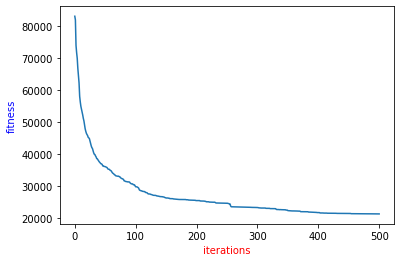

In [25]:
ga( graph,
    num_iters = 500,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 10,
    mutation_prob = 0.15,
    tournament_size = 10,
    )

## Hibrid genetski algoritam i redukovani vns:

In [26]:
def ga_rvns(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        rvns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    

code: [121, 101, 86, 13, 10, 3, 1, 0, 5, 7, 35, 58, 61, 24, 25, 23, 20, 17, 36, 38, 46, 42, 45, 40, 37, 39, 33, 30, 31, 29, 11, 9, 8, 34, 41, 43, 83, 104, 117, 140, 172, 173, 178, 171, 129, 110, 98, 100, 103, 126, 124, 125, 108, 77, 73, 68, 16, 6, 2, 4, 21, 32, 56, 63, 76, 78, 91, 96, 106, 107, 114, 119, 127, 123, 122, 53, 51, 55, 57, 60, 65, 44, 27, 28, 26, 14, 18, 92, 102, 138, 137, 160, 162, 163, 168, 175, 181, 193, 191, 192, 184, 165, 159, 132, 120, 116, 115, 111, 109, 99, 54, 49, 48, 47, 52, 50, 59, 71, 70, 81, 88, 89, 62, 64, 19, 15, 12, 22, 74, 90, 105, 128, 134, 142, 147, 150, 146, 143, 145, 148, 155, 144, 139, 133, 131, 136, 141, 153, 156, 149, 152, 151, 158, 166, 169, 170, 179, 177, 167, 161, 157, 154, 135, 130, 95, 94, 87, 82, 80, 72, 66, 67, 69, 75, 79, 93, 84, 85, 97, 113, 112, 118, 164, 176, 183, 174, 182, 185, 186, 189, 188, 190, 187, 180]
fitness: 16818.373614269116


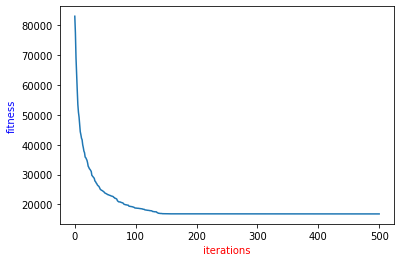

In [27]:
ga_rvns( graph,
    num_iters = 500,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 40,
    mutation_prob = 0.15,
    tournament_size = 15,
    )

## Hibrid genetski algoritam i VNS koji se primenjuje samo na najbolju jedinku u generaciji:

In [28]:
def ga_vns_best_only(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
                        
        #replace_population
        vns(graph,population[0], 7, 30, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    

In [29]:
# ga_vns_best_only( graph,
#     num_iters = 20,
#     use_elitism = True,
#     population_size = 1000,
#     elitism_size = 10,
#     mutation_prob = 0.15,
#     tournament_size = 10,
#     )

## Hibrid genetski algoritam i VNS koji se primenjuje na najbolju jedniku nakon kraja genetskog:

In [30]:
def ga_vns_piped(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    print(f'best indivudual fitness before another vns: {best_individual.fitness}')
    vns(graph, best_individual, 10, 100, 0.5)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)

In [31]:
# ga_vns_piped( graph,
#     num_iters = 20,
#     use_elitism = True,
#     population_size = 1000,
#     elitism_size = 10,
#     mutation_prob = 0.15,
#     tournament_size = 10,
#     )

## Hibrid genetski algoritam i VNS sa dinamicki promenljivom verovatnocom mutacije (povezana sa fitnesom jedinke):

In [32]:
def ga_rvns_dynamic_mutation_adjustment(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size, coef):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0

    for j in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
                        
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #mutation
            mutation(new_population[i],   mutation_prob - coef/new_population[i].fitness)
            mutation(new_population[i+1], mutation_prob - coef/new_population[i+1].fitness)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        rvns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters+1), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    plt.show()
    
    

code: [22, 12, 13, 16, 10, 6, 3, 1, 2, 4, 8, 9, 14, 18, 49, 48, 54, 53, 51, 52, 47, 40, 37, 46, 50, 67, 77, 86, 108, 126, 129, 136, 141, 137, 101, 73, 68, 21, 11, 26, 36, 38, 57, 60, 66, 72, 109, 111, 122, 123, 127, 132, 119, 114, 107, 106, 99, 83, 20, 17, 27, 28, 44, 82, 87, 91, 96, 80, 78, 76, 69, 63, 56, 59, 32, 23, 25, 24, 70, 75, 74, 71, 45, 43, 41, 34, 29, 31, 30, 33, 39, 42, 55, 65, 104, 105, 121, 140, 163, 168, 175, 181, 182, 183, 176, 180, 177, 179, 169, 165, 159, 142, 147, 146, 149, 153, 145, 139, 144, 148, 160, 162, 171, 193, 189, 186, 185, 155, 97, 85, 84, 89, 88, 79, 90, 92, 94, 95, 102, 112, 125, 124, 131, 133, 178, 188, 187, 192, 184, 170, 154, 135, 134, 130, 118, 113, 93, 62, 64, 19, 0, 5, 7, 15, 35, 58, 61, 81, 138, 173, 172, 156, 152, 151, 128, 120, 116, 115, 117, 150, 157, 158, 161, 166, 167, 164, 143, 110, 103, 98, 100, 174, 191, 190]
fitness: 17671.321798100664


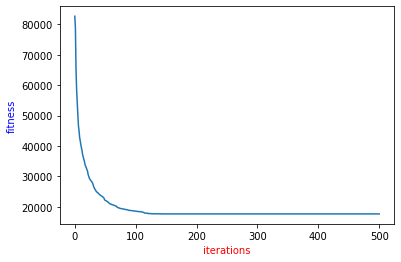

In [33]:
ga_rvns_dynamic_mutation_adjustment( graph,
    num_iters = 500,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 40,
    mutation_prob = 0.2,
    tournament_size = 15,
    coef = 1500
    )

In [34]:
0.20 - 4*1000/40265

0.10065813982366821

## Hibrid genetksi algoritam i VNS (manja populacija i broj iteracija zbog velike slozenosti):

In [35]:
def ga_vns(g,num_iters, use_elitism, elitism_size, mutation_prob, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0
        
    for _ in range(num_iters):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population)
            tmp.append(current_best_fitness)
            
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
            
            #mutation
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            vns(graph,new_population[i], 2, 5, 0.5)
            vns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        vns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    print(tmp)
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(num_iters), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    

In [36]:
# ga_vns( graph,
#     num_iters = 10,
#     use_elitism = True,
#     population_size = 150,
#     elitism_size = 16,
#     mutation_prob = 0.15,
#     tournament_size = 10,
#     )

# Hibrid ga + vns + dinamicka mutacija (povezana sa brojem iteracije)

In [37]:
def ga_rvns_dynamic_iteration_depandent_mutation(g,num_iters, use_elitism, elitism_size, tournament_size, population_size):
    #init population
    population = [Individual(g) for _ in range(population_size)]
    new_population = [Individual(g) for _ in range(population_size)]
    tmp = []
    if not use_elitism:
        elitism_size = 0

    for j in range(1,num_iters+1):
        if use_elitism:
            population.sort()
            tmp.append(population[0].fitness)
            new_population[:elitism_size] = population[:elitism_size]
        else:
            current_best_fitness = min(population).fitness
            tmp.append(current_best_fitness)
                        
        for i in range(elitism_size, population_size, 2):
            #selection
            parent1, parent1_idx = selection(population, tournament_size)
            parent2, _ = selection(population, tournament_size, parent1_idx)
            
            #crossover
            new_population[i].code , new_population[i+1].code = crossover(parent1, parent2)
                        
            #mutation
            mutation(new_population[i],  1/(2*j))
            mutation(new_population[i+1],1/(2*j))
            
            #calc_new_fitnesses
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
            
            #vns
            rvns(graph,new_population[i], 2, 5, 0.5)
            rvns(graph,new_population[i+1], 2, 5, 0.5)
            
            
        #replace_population
        rvns(graph,population[0], 3, 15, 0.5)
        population[:] = new_population[:]

    #find solution
    best_individual = min(population)
    tmp.append(best_individual.fitness)
    
    print(f"code: {best_individual.code}")
    print(f"fitness: {best_individual.fitness}")

    plt.plot(range(1,num_iters+2), tmp)
    plt.xlabel("iterations",color="red",fontsize=10)
    plt.ylabel("fitness",color="blue",fontsize=10)
    plt.show()

code: [176, 167, 169, 166, 161, 147, 135, 130, 128, 120, 116, 115, 119, 122, 123, 127, 132, 134, 142, 159, 165, 170, 177, 180, 183, 182, 174, 172, 173, 171, 178, 185, 188, 190, 191, 189, 186, 193, 181, 175, 168, 163, 153, 149, 156, 164, 158, 157, 154, 150, 143, 138, 118, 86, 13, 10, 6, 2, 1, 3, 0, 5, 16, 20, 17, 21, 36, 46, 52, 51, 47, 45, 40, 37, 30, 11, 4, 8, 9, 26, 38, 50, 66, 99, 109, 111, 114, 146, 151, 152, 140, 105, 82, 78, 76, 49, 18, 14, 29, 31, 34, 55, 57, 60, 80, 91, 96, 95, 102, 101, 112, 125, 131, 133, 136, 139, 144, 155, 160, 162, 148, 137, 121, 117, 107, 106, 104, 83, 72, 65, 67, 63, 69, 77, 74, 79, 93, 89, 88, 35, 58, 61, 108, 113, 124, 126, 110, 103, 100, 98, 81, 70, 25, 23, 32, 68, 73, 87, 94, 92, 90, 12, 7, 19, 64, 62, 15, 22, 24, 71, 59, 56, 44, 43, 41, 48, 54, 53, 42, 39, 33, 28, 27, 75, 84, 85, 97, 129, 141, 145, 179, 184, 192, 187]
fitness: 15902.953849014955


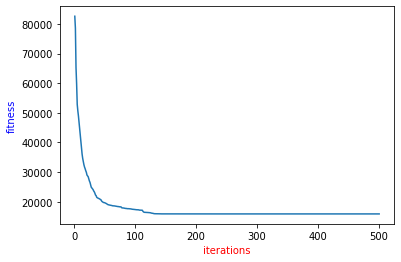

In [38]:
ga_rvns_dynamic_iteration_depandent_mutation( graph,
    num_iters = 500,
    use_elitism = True,
    population_size = 1000,
    elitism_size = 40,
    tournament_size = 15,
    )

In [39]:
0.20 - 1500/15215

0.10141307919815973